In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os

plt.rcParams.update({'font.size': 25})

In [20]:
# --------------------------------
# General parameters
# --------------------------------

BuddayFolder = "Budday2019Data"
AbaqusFolder = "AbaqusData"

# Parameters
Regions = ["Basal Ganglia", "Corona Radiata", "Corpus Callosum", "Cortex"]
Region = Regions[1]

Tests = ['Traction', 'Compression', 'Simple Shear']
Test  = Tests[1]

Models = ['Hybrid Neo-Hookean','Hybrid Ogden', 'Incompressible Ogden', 'Compressible Neo-Hookean', 'Compressible Ogden']
Model = Models[4]

Nus = [0.49, 0.45, 0.40]
Nu = Nus[0]

if Model == Models[0] or Model == Models[1]:
    Nselements = [5, 10]
else:
    Nselements = [5, 10, 20]
    
Nelements = Nselements[-1]

NSteps = [20, 10, 5]
NStep = NSteps[1]

# Sample parameters
Area = 25
Height = 5

In [21]:
# --------------------------------
# Import parameters
# --------------------------------

# Region of the brain
if Region == Regions[0]:
    Rn = "BasalGanglia"
    Rd = "BG"    
elif Region == Regions[1]:
    Rn = "CoronaRadiata"
    Rd = "CR"
elif Region == Regions[2]:
    Rn = "CorpusCallosum"
    Rd = "CC"
elif Region == Regions[3]:
    Rn = "Cortex"
    Rd = "C"
    
# Test type
if Test == Tests[0]:
    BuddayFile = "Tension_OgdenFEM_Dat.csv"
    BuddayExp = "Tension_ExpDat.csv"
    if Model == Models[3] or Model == Models[0]:
        AbaqusFile = "Tension_NeoHookSimultaneousParameters.csv"
    elif Model == Models[2] or Model == Models[1]:
        AbaqusFile = "Tension_OgdenSimultaneousParameters.csv" 
    elif Model == Models[4]:
        AbaqusFile = 'CR_Tension_OgdenMultiLoadOptm3Parameter_RF2_U2.csv'
    cols = [1,2]
elif Test == Tests[1]:
    BuddayFile = "Compression_OgdenFEM_Dat.csv"
    BuddayExp = "Compression_ExpDat.csv"
    if Model == Models[3] or Model == Models[0]:
        AbaqusFile = "Compression_NeoHookSimultaneousParameters.csv"
    elif Model == Models[2] or Model == Models[1]:
        AbaqusFile = "Compression_OgdenSimultaneousParameters.csv"
    elif Model == Models[4]:
        AbaqusFile = 'CR_Compression_OgdenMultiLoadOptm3Parameter_RF2_U2.csv'
    cols = [2,4]
elif Test == Tests[2]:
    cols = [1,2]
    BuddayFile = "SimpleShear_OgdenFEM_Dat.csv"
    BuddayExp = "SimpleShear_ExpDat.csv"
    if Model == Models[3] or Model == Models[0]:
        AbaqusFile = "SimpleShear_NeoHookSimultaneousParameters.csv"
    elif Model == Models[2] or Model == Models[1]:
        AbaqusFile = "SimpleShear_OgdenSimultaneousParameters.csv"
    elif Model == Models[4]:
        AbaqusFile = 'CR_SimpleShear_OgdenMultiLoadOptm3Parameter_RF1_U1.csv'

Compression of Corona Radiata using Compressible Ogden Model


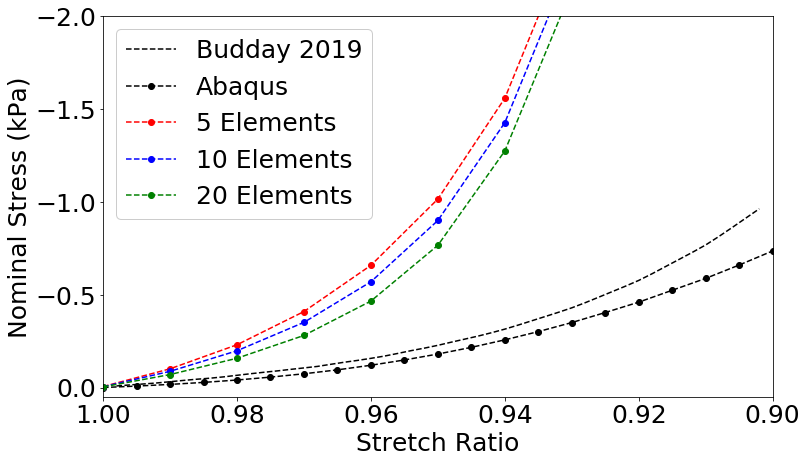

In [25]:
# --------------------------------
# Elements sensitivity analysis
# --------------------------------

print(Test, 'of', Region, 'using', Model, 'Model')

# Parameters of the plot
Xaxis = 'Stretches'
Colors = ['r', 'b', 'g']
plt.rc('figure', figsize=[12,7])
fig, ax = plt.subplots(1, 1)

# Import data
Buddaydf = pd.read_csv(os.path.join("..", BuddayFolder, Rn, Rd + "_" + BuddayFile),delimiter=";", decimal=",",names=['Stretches','Stresses'])
if Model == Models[4]:
#     Buddaydf = pd.read_csv(os.path.join("..", BuddayFolder, Rn, Rd + "_" + BuddayExp),delimiter=";", decimal=",",names=['Stretches','Stresses'])
    Abaqusdf = pd.read_csv(os.path.join("..", AbaqusFolder, AbaqusFile),delimiter=";", header=None, usecols=[0,1], names = ['Displacement', 'Reaction Force'])
else:
    Abaqusdf = pd.read_csv(os.path.join("..", AbaqusFolder, AbaqusFile),delimiter="\s+", header=None, usecols=cols, names = ['Reaction Force', 'Displacement'])

# Compute stress and strain
Abaqusdf['Stress']= Abaqusdf['Reaction Force'] / Area
if Test == Tests[2]:
    Abaqusdf['Strain']= Abaqusdf['Displacement'] / Height
else:
    Abaqusdf['Strain']= Abaqusdf['Displacement'] / Height + 1

# Plot Budday and Abaqus results
if Model == Models[1] or Model == Models[2] or Model == Models[4]:
    Buddaydf.plot(ax = ax, x = 'Stretches', y = 'Stresses', color = 'k', linestyle = '--', label = 'Budday 2019')
Abaqusdf.plot(ax = ax, x = 'Strain', y = "Stress", color = 'k', linestyle = '--', marker = 'o', label = 'Abaqus')

# Add FEniCS results
for i, elem in enumerate(Nselements):
    
    # Define path of the results
    Results = f'Nu{Nu}_{elem}Elements_{Test}Stresses'
    Path = os.path.join('Results', Model, str(NStep) + ' Steps', Results)

    # Import results
    df = pd.read_pickle(Path)

    # Plot
#     ax.plot(df.Stretches, df.pzz, color = Colors[i], linestyle = '--', marker = 'o', label = str(elem) + ' Elements')
    ax.plot(df.Stretches, df.P, color = Colors[i], linestyle = '--', marker = 'o', label = str(elem) + ' Elements')

if Test  == Tests[1]:
    ax.set_ylim(0.05,-2)
    ax.set_xlim(1,df['Stretches'][10])
    
if Test == Tests[2]:
    ax.set_xlim(0,df['Stretches'][10])
    ax.set_xlabel('Amount of Shear')
    ax.set_ylabel('Shear Stress (kPa)')
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
    
else:
#     ax.set_xlim(1,df['Stretches'][10])
    ax.set_xlabel('Stretch Ratio')
    ax.set_ylabel('Nominal Stress (kPa)')
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.02))
    
ax.legend(loc='upper left', frameon=True, framealpha=1)
plt.savefig(os.path.join('Results', 'ElementsSensitivity_' + Test + '_' + Model + '_Nu' + str(Nu) + '.pdf'))

Compression of Corona Radiata using Hybrid Neo-Hookean Model
0.733351545455
9.31518836364


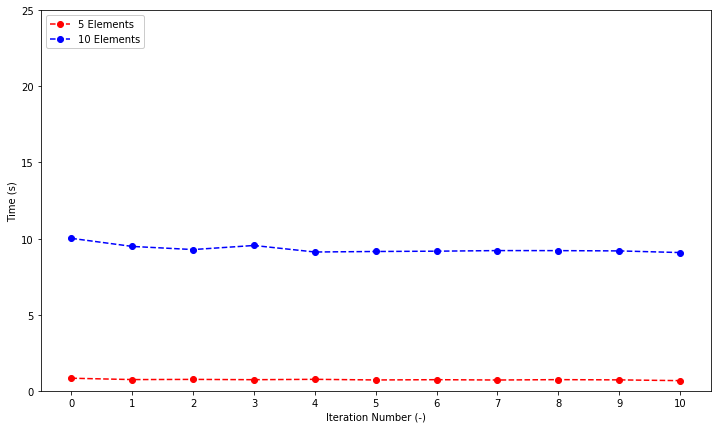

In [5]:
# --------------------------------
# Nelements Iteration times
# --------------------------------

print(Test, 'of', Region, 'using', Model, 'Model')

# Parameters of the plot
Xaxis = 'Stretches'
Colors = ['r', 'b', 'g']
plt.rc('figure', figsize=[12,7])
fig, ax = plt.subplots(1, 1)

# Add FEniCS results
for i, elem in enumerate(Nselements):
    
    # Define path of the results
    Results = f'Nu{Nu}_{elem}Elements_{Test}Stresses'
    Path = os.path.join('Results', Model, str(NStep) + ' Steps', Results)

    # Import results
    df = pd.read_pickle(Path)
    print(df['Itimes'].mean() )

    # Plot
    ax.plot(df.index, df.Itimes, color = Colors[i], linestyle = '--', marker = 'o', label = str(elem) + ' Elements')
    
ax.set_xlabel('Iteration Number (-)')
ax.set_ylabel('Time (s)')
ax.set_ylim(0,25)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend(loc='upper left', frameon=True, framealpha=1)
plt.savefig(os.path.join('Results', 'ITime_Elements_' + Test + '_' + Model + '_Nu' + str(Nu) + '.pdf'))

In [6]:
# --------------------------------
# Nu sensitivity analysis
# --------------------------------

if Model == Models[2] or Model == Models[3] or Model == Models[4]:

    print(Test, 'of', Region, 'using', Model, 'Model')

    # Parameters of the plot
    Xaxis = 'Stretches'
    Colors = ['r', 'b', 'g']
    plt.rc('figure', figsize=[12,7])
    fig, ax = plt.subplots(1, 1)

    # Import data
    Buddaydf = pd.read_csv(os.path.join("..", BuddayFolder, Rn, Rd + "_" + BuddayFile),delimiter=";", decimal=",",names=['Stretches','Stresses'])
    if Model == Models[4]:
        Abaqusdf = pd.read_csv(os.path.join("..", AbaqusFolder, AbaqusFile),delimiter=";", header=None, usecols=[0,1], names = ['Displacement', 'Reaction Force'])
    else:
        Abaqusdf = pd.read_csv(os.path.join("..", AbaqusFolder, AbaqusFile),delimiter="\s+", header=None, usecols=cols, names = ['Reaction Force', 'Displacement'])

    # Compute stress and strain
    Abaqusdf['Stress']= Abaqusdf['Reaction Force'] / Area
    if Test == Tests[2]:
        Abaqusdf['Strain']= Abaqusdf['Displacement'] / Height
    else:
        Abaqusdf['Strain']= Abaqusdf['Displacement'] / Height + 1

    # Plot Budday and Abaqus results
    if Model == Models[1] or Model == Models[2] or Model == Models[4]:
        Buddaydf.plot(ax = ax, x = 'Stretches', y = 'Stresses', color = 'k', linestyle = '--', label = 'Budday 2019')
    Abaqusdf.plot(ax = ax, x = 'Strain', y = "Stress", color = 'k', linestyle = '--', marker = 'o', label = 'Abaqus')

    # Add FEniCS results
    for i, elem in enumerate(Nus):

        # Define path of the results
        Results = f'Nu{elem}_{Nelements}Elements_{Test}Stress'
        Path = os.path.join('Results', Model, str(NStep) + ' Steps', Results)

        # Import results
        df = pd.read_pickle(Path)

        # Plot
#         ax.plot(df.Stretches, df.pzz, color = Colors[i], linestyle = '--', marker = 'o', label = 'Nu = '+ str(elem))
        ax.plot(df.Stretches, df.P, color = Colors[i], linestyle = '--', marker = 'o', label = 'Nu = '+ str(elem))
        
    if Test  == Tests[1]:
#         ax.set_ylim(0,df['pzz'][10]*1.5)
        ax.set_ylim(0.1,df['P'][10]*1.25)
        ax.set_xlim(1,df['Stretches'][10])

    if Test == Tests[2]:
        ax.set_xlim(0,df['Stretches'][10])
        ax.set_xlabel('Amount of Shear')
        ax.set_ylabel('Shear Stress (kPa)')
    else:
    #     ax.set_xlim(1,df['Stretches'][10])
        ax.set_xlabel('Stretch Ratio')
        ax.set_ylabel('Nominal Stress (kPa)')

#     ax.set_ylim(0.05,-1)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
    ax.legend(loc='upper left', frameon=True, framealpha=1)
    plt.savefig(os.path.join('Results', 'NuSensitivity_' + Test + '_' + Model + '_' + str(Nelements) + 'Elements.pdf'))

In [7]:
# --------------------------------
# Nu Iteration times
# --------------------------------

if Model == Models[2] or Model == Models[3] or Model == Models[4]:

    print(Test, 'of', Region, 'using', Model, 'Model')

    # Parameters of the plot
    Xaxis = 'Stretches'
    Colors = ['r', 'b', 'g']
    plt.rc('figure', figsize=[12,7])
    fig, ax = plt.subplots(1, 1)

    # Add FEniCS results
    for i, elem in enumerate(Nus):

        # Define path of the results
        Results = f'Nu{elem}_{Nelements}Elements_{Test}Stresses'
        Path = os.path.join('Results', Model, str(NStep) + ' Steps', Results)

        # Import results
        df = pd.read_pickle(Path)

        # Plot
        ax.plot(df.index, df.Itimes, color = Colors[i], linestyle = '--', marker = 'o', label = 'Nu = '+ str(elem))

    ax.set_xlabel('Iteration Number (-)')
    ax.set_ylabel('Time (s)')
    ax.set_ylim(0,16)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.legend(loc='lower left', frameon=True, framealpha=1)
    plt.savefig(os.path.join('Results', 'ITime_Nu_' + Test + '_' + Model + '_' + str(Nelements) + 'Elements.pdf'))

Compression of Corona Radiata using Hybrid Neo-Hookean Model


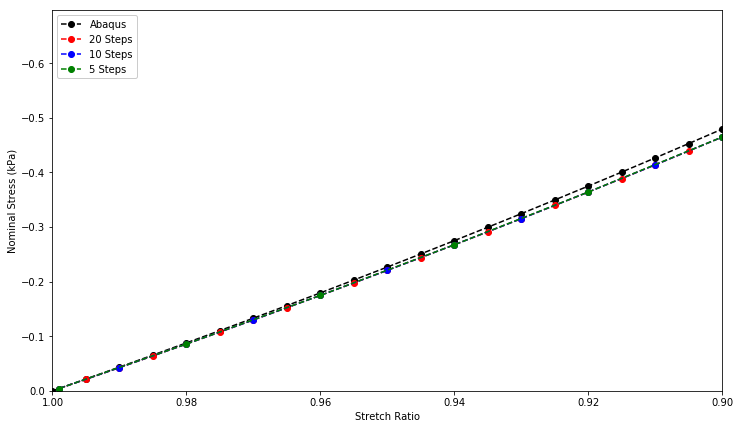

In [8]:
# --------------------------------
# Step size sensitivity analysis
# --------------------------------

if Model == Models[0] or Model == Models[1]:

    print(Test, 'of', Region, 'using', Model, 'Model')

    # Parameters of the plot
    Xaxis = 'Stretches'
    Colors = ['r', 'b', 'g']
    plt.rc('figure', figsize=[12,7])
    fig, ax = plt.subplots(1, 1)

    # Import data
    Buddaydf = pd.read_csv(os.path.join("..", BuddayFolder, Rn, Rd + "_" + BuddayFile),delimiter=";", decimal=",",names=['Stretches','Stresses'])
    if Model == Models[4]:
        Abaqusdf = pd.read_csv(os.path.join("..", AbaqusFolder, AbaqusFile),delimiter=";", header=None, usecols=cols, names = ['Displacement', 'Reaction Force'])
    else:
        Abaqusdf = pd.read_csv(os.path.join("..", AbaqusFolder, AbaqusFile),delimiter="\s+", header=None, usecols=cols, names = ['Reaction Force', 'Displacement'])

    # Compute stress and strain
    Abaqusdf['Stress']= Abaqusdf['Reaction Force'] / Area
    if Test == Tests[2]:
        Abaqusdf['Strain']= Abaqusdf['Displacement'] / Height
    else:
        Abaqusdf['Strain']= Abaqusdf['Displacement'] / Height + 1

    # Plot Budday and Abaqus results
    if Model == Models[1] or Model == Models[2]:
        Buddaydf.plot(ax = ax, x = 'Stretches', y = 'Stresses', color = 'k', linestyle = '--', label = 'Budday 2019')
    Abaqusdf.plot(ax = ax, x = 'Strain', y = "Stress", color = 'k', linestyle = '--', marker = 'o', label = 'Abaqus')

    # Add FEniCS results
    for i, elem in enumerate(NSteps):

        # Define path of the results
        Results = f'Nu{Nu}_{Nelements}Elements_{Test}Stresses'
        Path = os.path.join('Results', Model, str(elem) + ' Steps', Results)

        # Import results
        df = pd.read_pickle(Path)

        # Plot
        ax.plot(df.Stretches, df.pzz, color = Colors[i], linestyle = '--', marker = 'o', label = str(elem) + ' Steps')

    if Test  == Tests[1]:
        ax.set_ylim(0,df['pzz'][5]*1.5)
        ax.set_xlim(1,df['Stretches'][5])

    if Test == Tests[2]:
#         ax.set_xlim(0,df['Stretches'][10])
        ax.set_xlabel('Amount of Shear')
        ax.set_ylabel('Shear Stress (kPa)')
        ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))

    else:
    #     ax.set_xlim(1,df['Stretches'][10])
        ax.set_xlabel('Stretch Ratio')
        ax.set_ylabel('Nominal Stress (kPa)')
        ax.xaxis.set_major_locator(plt.MultipleLocator(0.02))
        
#     ax.set_ylim(0.05,-1.65)
    ax.legend(loc='upper left', frameon=True, framealpha=1)
    plt.savefig(os.path.join('Results', 'StepSensitivity_' + Test + '_' + Model + '_' + str(Nelements) + 'Elements.pdf'))

Compression of Corona Radiata using Hybrid Neo-Hookean Model


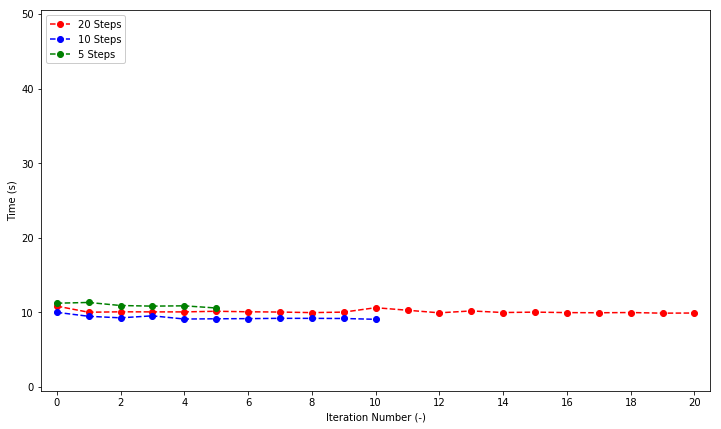

In [9]:
# --------------------------------
# Steps Iteration times
# --------------------------------

if Model == Models[0] or Model == Models[1]:

    print(Test, 'of', Region, 'using', Model, 'Model')

    # Parameters of the plot
    Xaxis = 'Stretches'
    Colors = ['r', 'b', 'g']
    plt.rc('figure', figsize=[12,7])
    fig, ax = plt.subplots(1, 1)

    # Add FEniCS results
    for i, elem in enumerate(NSteps):

        # Define path of the results
        Results = f'Nu{Nu}_{Nelements}Elements_{Test}Stresses'
        Path = os.path.join('Results', Model, str(elem) + ' Steps', Results)

        # Import results
        df = pd.read_pickle(Path)

        # Plot
        ax.plot(df.index, df.Itimes, color = Colors[i], linestyle = '--', marker = 'o', label = str(elem) + ' Steps')

    ax.set_xlabel('Iteration Number (-)')
    ax.set_ylabel('Time (s)')
    ax.set_xlim(-0.5,20.5)
    ax.set_ylim(-0.5,50.5)
    ax.xaxis.set_major_locator(plt.MultipleLocator(2))
    ax.legend(loc='upper left', frameon=True, framealpha=1)
    plt.savefig(os.path.join('Results', 'ITime_Steps_' + Test + '_' + Model + '_' + str(Nelements) + 'Elements.pdf'))